In [2]:
from pylab import *

import os
import sys
home = os.environ["HOME"]
sys.path.append(home+'/bin/python')

import radmc3dPy as rpy
import numpy as np
import os
from scipy import interpolate
#from models import *
from IPython import display
import models as wedge

## Example 1 Tutorial: Basic Functionality of WEDGEFORD
This is a notebook to get acquainted with the base tools in this code. It will take you through the basic components of a parametric model in WEDGEFORD, thermal radiative transfer, UV radiative transfer, and how inputs are made for the chemical code. 


Let's start with an example model using the default parameters. 
Here we're going to load from the model parameters used in `/out/example_1/` straight from the `pars.pkl` file in the folder and print the parameters being used for the model. You can always copy a `pars.pkl` file from any directory you have into a new output directory and load from that new directory using `load_model` to start working with another version of the model.

`m1` is now the name of our output object and `m1.m` is attribute for the model properties themselves, you can directly access parameters for different components as attributes,
for example `m1.m.disk` are the disk parameters, `m1.m.star` are the star parameters, and etc.

```print(m1.m.__doc__)``` for a list of the available attributes

If you've already run radiative transfer for a model and want to generate the chemistry files, you can load in the model and proceed down to "Setting up the Chemistry"

In [3]:
outdir='out/example_1/'
m1 = wedge.load_model(outdir)
m1.m.print_params()

directory exists - will overwrite current model if you write to it!
Loading from model directory:/Users/schwarz/Documents/GitHub/wedgeford/out/example_1/
Reading /Users/schwarz/Documents/GitHub/wedgeford/out/example_1/wavelength_micron.inp
stellar_params: {'Ms': 1, 'Rs': 2.0, 'Ts': 5000, 'accrate': 1e-07, 'f': 0.01}
disk_params: {'Mdisk': 0.1, 'Mfrac': [0.01, 0.02], 'R0': [5, 5], 'H0': [1, 0.2], 'p': [-1, -1], 'Rdisk': [125, 125], 'Tfac': 1, 'q': 0.5, 'hydro': [None, None, None]}
envelope_params: {'Min': 1e-06, 'Rc': 125, 'rho_amb': 1e-25, 'rho_0': 3e-22, 'theta_min': 25, 'exf': 0.25, 'Rmax': 15000.0, 'd2g': 0.01, 'shock': False, 'nstreams': 1, 'stream_frac': 1}
grid_params: {'N': [180, 90, 48], 'min': [0.1, 0.19634954084936207, 0], 'max': [400, 1.5707963267948966, 6.283185307179586], 'spacing': ['log', 'lin', 'lin']}
dust_params: {'rho_si': 3.1518, 'amin_chem': 0.06, 'amax_ism': 1.0, 'amin': [0.005, 0.005], 'amax': [1, 1000.0], 'apow': [3.5, 3.5]}
RT_params: {'cr_model': 'ssx', 'zetac

At this point, the only thing the code will look to write are the spatial and wavelength grid files for radmc-3d, if they're not already present in the folder. 

This is a very basic, disk with an axisymmetric Ulrich envelope that has an opening angle of 25 degrees. The radiation will include some external ISRF, a small fraction of Lyman alpha, and will compute the x-ray radiation field. 


What does it look like?

Well we can pass our output object `m1` into `plot_components` with the number of the fluid component (0 for gas, 1 for small dust, and 2 for large dust) see a basic plot of the density in the disk, envelope, and the whole embedded system.

For reference: the disk panels have solid white lines to demarcate the first three scale heights in the disk.
The envelope panels show the streamlines as white dashed lines. 

/Users/schwarz/anaconda3/lib/python3.11/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/schwarz/anaconda3/lib/python3.11/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


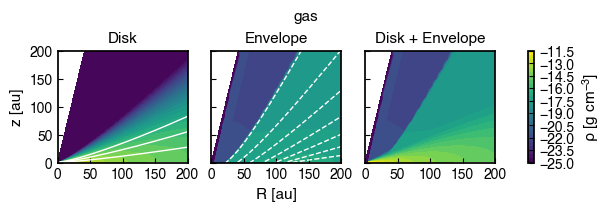

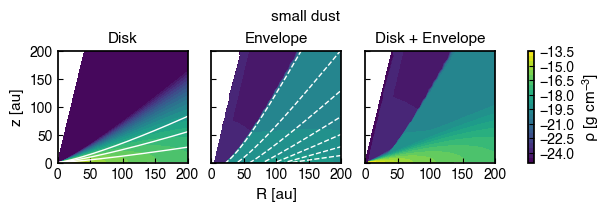

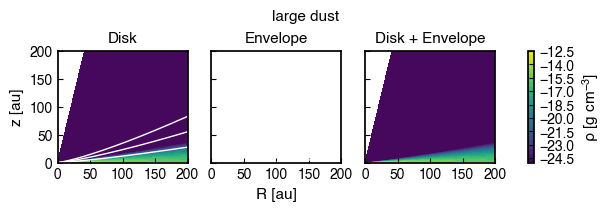

In [4]:
wedge.plot_components(m1,fluid=0,rlim=200)
wedge.plot_components(m1,fluid=1,rlim=200)
wedge.plot_components(m1,fluid=2,rlim=200)

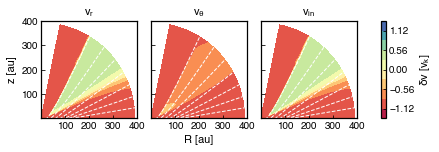

In [4]:
wedge.plot_velocities(m1)

Now let's see what's going into the radiation transfer. First we'll write the files that radmc3d will need to compute for radiative transfer. For this part, you'll either need to have optool installed to generate the opacities that correspond to the input parameters or have two files of your own defined in a `dust_opac.inp` file. 

In [5]:
#If you have your own opacity files and don't wish to run optool, put their names in here
filename_small_dust = 'sm_maps_std'
filename_large_dust = 'lg_maps_std'

wedge.write_opacities(m1.m,ndust=2,filenames=[filename_small_dust,filename_large_dust],update=True)
#wedge.write_opacities(m1,ndust=2,update=False) #changed m1 to m1.m

fname sm_maps_std
/Users/schwarz/Documents/GitHub/wedgeford/out/example_1/dustkappa_sm_maps_std.inp: user dust opacity file found in model directory
Updating x-ray opacities
fname lg_maps_std
/Users/schwarz/Documents/GitHub/wedgeford/out/example_1/dustkappa_lg_maps_std.inp: user dust opacity file found in model directory
Updating x-ray opacities
updating dustopac.inp


The `prep_thermal_transfer` function will check for and write all the necessary files for radmc3d to perform thermal transfer. This means that if you already have files written from some other code, like for example your own spectrum for stars.inp, the function won't overwrite them and save you some I/O effort.

If you've changed some of the model parameters and now want to save a record of these as the new setup in the `pars.pkl` file to load later you can run:

```update_model(m1,**m1.m.print_params())```


*A note on file system hygiene:*

If you have old files hanging around that don't match the parameters you want to run with and *do* want to overwrite them, like maybe you changed the initial parameters for the model grid and didn't scrub the folder, you could use `overwrite_model` instead of `prep_thermal_transfer`. However, this will in fact overwrite files in the folder so **use with caution**. Sometimes it may just make more sense to delete whatever files need to be re-generated and re-run `prep_thermal_transfer`


In [6]:
#wedge.overwrite_model(m1)
wedge.prep_thermal_transfer(m1)

Reading /Users/schwarz/Documents/GitHub/wedgeford/out/example_1/wavelength_micron.inp
Writing /Users/schwarz/Documents/GitHub/wedgeford/out/example_1/wavelength_micron.inp
Writing stars.inp
updating radmc3d.inp


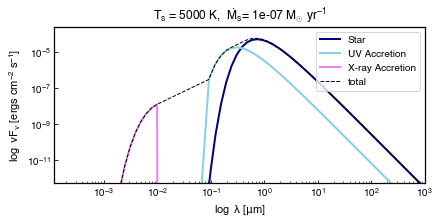

In [7]:
wedge.plot_flux_components(m1)

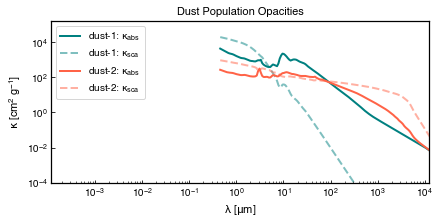

In [8]:
wedge.plot_opacities(m1)

#### Thermal Radiative Transfer
Okay, after this, we're now we're ready to run the thermal transfer for our calculation!
You can run radmc from the command line in the run folder or use the wrapped command specifying multiple threads here:

In [7]:

wedge.do_thermal_transfer(m1,nt=8)
#just running in terminal for now

Now lets take a look at the plots! There are some convenience functions here for plotting the outputs, but you can always access the output data itself by calling ```m1.read_rho()``` or ```m1.read_Tdust()``` to read in the full 3D arrays that are in `dust_density.inp` and `dust_temperature.dat`.


In [9]:
m1.read_rho()
m1.read_Tdust()
print('Temperature data is stored in m1.T with keys: ', m1.T.keys())
print('Density data is stored in m1.rho with keys:', m1.rho.keys())

Reading /Users/schwarz/Documents/GitHub/wedgeford/out/example_1/dust_density.inp
Reading /Users/schwarz/Documents/GitHub/wedgeford/out/example_1/gas_density.inp
Reading /Users/schwarz/Documents/GitHub/wedgeford/out/example_1/dust_temperature.dat
Temperature data is stored in m1.T with keys:  dict_keys(['dust'])
Density data is stored in m1.rho with keys: dict_keys(['dust1', 'dust2', 'gas'])


`plot_dustRT` will show the dust density as read in by RADMC-3D and the dust temperature that is calculated as a result.

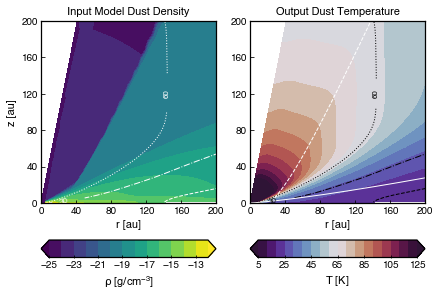

In [9]:
wedge.plot_dustRT(m1,rlim=200)

From here, you can make images of the dust continuum, use this as a constraint on the radiation temperature for running a three dimensional model, etc.

#### High Energy Radiative Transfer
Now, let's get ready to compute the UV and x-ray radiation fields. For this, the code will update the opacities in the x-ray, adding in the opacity contribution of the gas to the small dust component in the envelope, assuming the envelope dust to gas ratio and write a set of wavelength points to compute the field over into `mcmono_wavelength_micron.inp` 
(By default 5 in the UV and 5 in the x-ray).

fname 
Updating x-ray opacities
fname 
Updating x-ray opacities
updating dustopac.inp
Writing /Users/schwarz/Documents/GitHub/wedgeford/out/example_1/mcmono_wavelength_micron.inp
writing gas_density.inp
updating radmc3d.inp


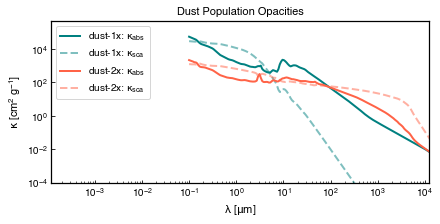

In [10]:
wedge.prep_he_transfer(m1,nu=5,nx=8)
wedge.plot_opacities(m1,xray=True)

Then running the `do_he_transfer` will run a multi-threaded `radmc mcmono` command to produce a `mean_intensity.out` file.

In [ ]:
wedge.do_he_transfer(m1,nphot=100000,nt=4,prep=False)

Here, again, we can use a convenience function to plot the integrated intensity of the radiation field, separating out the uv and x-ray contributions.
The full 4D array (spatial,wavelength) is the output of the `m1.read_Jnu` function, while running `m1.calc_Jint(field='uv')` will assign `m1.J['uv']` the value of the integrated intensity in the uv.

In [11]:
wedge.plot_radiation_field(m1,rlim=200,field='uv',levels=np.linspace(0,14,15))

TypeError: plot_radiation_field() got an unexpected keyword argument 'levels'

In [12]:
wedge.plot_radiation_field(m1,rlim=200,field='xray',levels=np.linspace(0,12,13))

TypeError: plot_radiation_field() got an unexpected keyword argument 'levels'

#### Estimating the Gas Temperature
For chemistry calculations or molecular line transfer, we may also need the gas temperature. While radmc can assume Tgas = Tdust, we can also use the information in the 3D integrated UV field in order to make an estimate of the temperature. 

The `m1.calc_Tgas` function identifies regions of the model where photo-dissociation is likely and cross references the cell-by-cell values of the UV field and number density with the surface temperature grid from the [PDR Toolbox](https://dustem.astro.umd.edu/index.html) to assign a gas temperature. The PDR models from which the temperature is pulled assume an ISM abundance and account for a menagerie of heating and cooling processes at work in PDR regions. 

The resulting gas temperature is now stored in `m1.T['gas']` alongside `m1.T['dust']`, so we can even take a comparison look.

Here in this example plot, which also shows how you can use `plot_slice` to plot array quantities, we can see how the PDR surface corresponds to the cavity surface and how we can get the classic two fingered temperature in the gas temperature distribution.

integrating uv field
Reading /Users/schwarz/Documents/GitHub/wedgeford/out/example_1/mcmono_wavelength_micron.inp
Reading /Users/schwarz/Documents/GitHub/wedgeford/out/example_1/mcmono_wavelength_micron.inp


Text(0.5, 1.0, '$T_{\\rm gas}$ [K]')

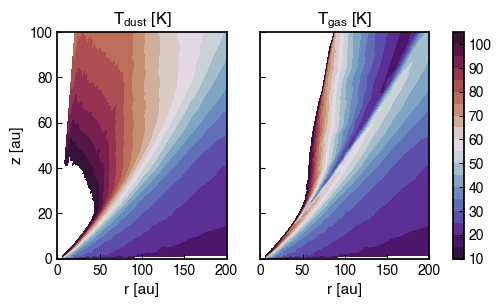

In [14]:
m1.calc_Tgas(ndim=3)
f,ax = subplots(1,2,sharey='row',dpi=100)
f.set_size_inches(6,3)
levels=np.arange(10,110,5)
sca(ax[0])
wedge.plot_slice(m1,rho=m1.T['dust'],log=False,cmap='twilight_shifted',levels=levels)
sca(ax[1])
im=wedge.plot_slice(m1,rho=m1.T['gas'],log=False,cmap='twilight_shifted',levels=levels)
colorbar(im,ax=ax)
ax[0].set_ylabel('z [au]')
for a in ax:
    a.set_xlim(0,200)
    a.set_ylim(0,100)
    a.set_xlabel('r [au]')
ax[0].set_title(r'$T_{\rm dust}$ [K]')
ax[1].set_title(r'$T_{\rm gas}$ [K]')

At this point, you can save the gas temperature to file by calling `write_gas_temperature(m1.m,Tgas=m1.T['gas'])` which will write a file in radmc format for the gas temperature if you want to run line transfer down the line, or want to input in somewhere else.

You can get a rundown of all the outputs from radmc stored as attributes with `m1.__doc__`

In [15]:
wedge.write_gas_temperature(m1.m,Tgas=m1.T['gas'])

writing gas_temperature.inp


In [16]:
4*80/133/3


0.8020050125313283

### Line Images w/o Chemistry

In [17]:
m1.m.print_params()

stellar_params: {'Ms': 1, 'Rs': 2.0, 'Ts': 5000, 'accrate': 1e-07, 'f': 0.01}
disk_params: {'Mdisk': 0.1, 'Mfrac': [0.01, 0.02], 'R0': [5, 5], 'H0': [1, 0.2], 'p': [-1, -1], 'Rdisk': [125, 125], 'Tfac': 1, 'q': 0.5, 'hydro': [None, None, None]}
envelope_params: {'Min': 1e-06, 'Rc': 125, 'rho_amb': 1e-25, 'rho_0': 3e-22, 'theta_min': 25, 'exf': 0.25, 'Rmax': 15000.0, 'd2g': 0.01, 'shock': False, 'nstreams': 1, 'stream_frac': 1}
grid_params: {'N': [180, 90, 48], 'min': [0.1, 0.19634954084936207, 0], 'max': [400, 1.5707963267948966, 6.283185307179586], 'spacing': ['log', 'lin', 'lin']}
dust_params: {'rho_si': 3.1518, 'amin_chem': 0.06, 'amax_ism': 1.0, 'amin': [0.005, 0.005], 'amax': [1, 1000.0], 'apow': [3.5, 3.5]}
RT_params: {'cr_model': 'ssx', 'zetacr': 1.3e-17, 'G0': 1, 'viscous_heating': False, 'fLya': 0.0001, 'xray': True}


In [18]:
mu = 2.36
mh = 1.67e-24 # mass of hydrogen cgs

In [19]:
molecules={'names':['c18o']}
molecules['xh2'] = np.array([1e-4/557])

In [20]:
nH2 = m1.m.rho_embedded(fluid=0)/((mu*mh))

nCO = nH2*molecules['xh2'][0]

Tco = np.moveaxis(m1.T['gas'],0,1)
freezeout = np.where(Tco < 20.0)
nCO[freezeout] = 1e-10

In [21]:
wedge.write_molecule_density(m1.m,molecules['names'],abundances=[nCO])

writing /Users/schwarz/Documents/GitHub/wedgeford/out/example_1/numberdens_c18o.inp


In [22]:
wedge.write_gas_temperature(m1.m,m1.T['gas'])
wedge.write_velocities(m1.m)
wedge.write_lines(m1.m,names=molecules['names'])

writing gas_temperature.inp
writing gas_velocity.inp


True

In [23]:
5000/292/0.05

342.4657534246575

In [24]:
npix = 342
sizeau = 2000
mol = 1
width = 6.0
nlam = 12
incl = 45.
pa = 0.0
command = './radmc3d image iline 2 widthkms {} linenlam {} incl {} posang {} noscat doppcatch'.format(width,nlam,incl,pa)
os.system(command)


0

In [25]:
im = rpy.image.readImage()

In [26]:
im.writeFits(fname='big_c18o_example.fits', dpc=293., coord='03h43m56s 32d00m40s',
            casa=False, wav0=3.1)#casa=True thorws an error

### Setting up the Chemistry
Now if we want to set up the chemistry for use with our chemistry code, we can import the `prepchem` module and start a chemistry model based on the physical model we've created and run through radmc. 

If you've already run the thermal and high energy transfer, you can load in the model and start straight from here, it will read in and compute everything else it needs along the way.

Initializing the chemistry disk will create a new run directory in the [/chemistry/environ](./chemistry/environ/) directory that the chemical code will look for inputs from.

The chemical code runs on individual radii with a certain number of vertical radii in 2D, so we need to regrid the data, taking an azimuthal average. You can specify your own radial and vertical grid points in the original call to chemdisk where rgrid are the radial grid points and zgrid are the vertical grid points for z/r (*note: not z*)
or use the default gridding which logarithmically spaces the two, with the vertical points going up to the cavity boundary at large radii. For points that lie outside of the original model domain, values are interpolated based on nearby data for easier I/O and behavior at the boundary but are not being captured by the model. If you want those points in your chemical analysis, make your original model domain larger!

We can look at how the data is being re-gridded with the `plot_prepchem` convenience function.

In [ ]:
import models.prepchem as wc
c1 = wc.chemdisk(m1,chemdir='/example_1/',rgrid=None,zgrid=None)
wc.plot_prechem(c1)


In [ ]:
wc.write_chem_inputs(c1)

In [ ]:
def run_diagnostic_rad(self,radval=None):
    environ_dir = self.chemdir.split('chemistry')[-1]
    environ_dir = self.rundir + 'environ/'
    radius_files = [file for file in os.listdir(environ_dir) if 'environ.inp' in file]
    radii  = [ r.split('1environ.inp.e1.')[-1] for r in radius_files]
    if radval is None:
        radval = radii[0]
        filename = 'environ/' + radius_files[0]
    else:
        radval = float(radii[np.abs(np.array(radii).astype(float)-radval).argmin()])
        filename = 'environ/' + radius_files[np.abs(np.array(radii).astype(float)-radval).argmin()]
    inputfile = '0io.inp '
    command ='./disk_chemistry ' +  inputfile +  filename + ' > ' + 'code.out.r' + str(radval) + '.out &'
    print(command)
    if os.getcwd() != self.rundir:
        os.chdir(self.rundir)
    os.system(command)
    
run_diagnostic_rad(c1,radval=16)

In [ ]:
radius_files = [ c1.chemdir + file for file in os.listdir(c1.chemdir) if 'environ.inp' in file]
radii  = [ r.split('1environ.inp.e1.')[-1] for r in radius_files]
out_files = [c1.chemdir + 'code.out.r' + r + '.out' for r in radii]
command = 'echo'

In [ ]:
def get_species_data(self,name,radval=None):
    environ_dir = self.rundir + 'environ/'
    radius_files = [file for file in os.listdir(environ_dir) if 'environ.inp' in file]
    radii  = [ r.split('1environ.inp.e1.')[-1] for r in radius_files]
    if radval is None:
        radval = radii[0]
    else:
        radval = float(radii[np.abs(np.array(radii).astype(float)-radval).argmin()])
    filename = 'r' + str(radval) + '_e1_2d.out'
    #nspec = float(np.loadtxt(self.rundir+filename,max_rows=1,comments="none",dtype='str')[-1])
    time_arr = np.array([])
    with open(self.rundir+filename, 'r') as f:
        count = 0
        for line in f:
            if line.strip(' ').startswith('time'):
                time = line.split('=')[-1]
                time_arr = np.append(time_arr,float(time))
            if line.startswith(name):
                vals = np.array([val for val in line.strip('\n').split(name)[-1].split(' ') if val != '']).astype(float)
                count += 1
   
    
    #time = float(np.loadtxt(self.rundir+filename,max_rows=1,comments="none",dtype='str')[-1])
    #nspec = 638
    
    
get_species_data(c1,'C+',radval=16)